In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from time import strftime

## Data Preprocessing

### Loading the dataset: Brazilian E-commerce Public Dataset by Olist

In [32]:
#  dataset on product info
products_df = pd.read_csv("data/olist_products_dataset.csv")                    #  shows product information as advertised on the site
product_trans_df = pd.read_csv("data/product_category_name_translation.csv")    #  shows product name translations

#  datasets on orders info 
order_only_df = pd.read_csv("data/olist_orders_dataset.csv",                    #  * MAIN DATASET: shows order transactions 
                            parse_dates=["order_purchase_timestamp",
                                         "order_approved_at",                
                                         "order_delivered_carrier_date",     
                                         "order_delivered_customer_date",    
                                         "order_estimated_delivery_date"])                                   
order_items_df = pd.read_csv("data/olist_order_items_dataset.csv",              #  shows order/product price + shipping fee
                             parse_dates=["shipping_limit_date"])              
order_payments_df = pd.read_csv("data/olist_order_payments_dataset.csv")        #  shows order payment total + method
order_reviews_df = pd.read_csv("data/olist_order_reviews_dataset.csv",          #  shows order reviews (numerical + text)
                               parse_dates=["review_creation_date",
                                            "review_answer_timestamp"])          

#  datasets on customer and seller
customer_df = pd.read_csv("data/olist_customers_dataset.csv")                   #  shows customer info (location)
seller_df = pd.read_csv("data/olist_sellers_dataset.csv")                       #  shows sellenr info (location)

#  dataset on geolocation/coordinates of cities/states in Brazil
geolocation_df = pd.read_csv("data/olist_geolocation_dataset.csv")              #  shows coordinates of locations in Brazil (customer & seller position)

![data schema of Olist dataset](notebook_images/data_schema.png)

In [33]:
df_dict = {
    "products_df": products_df,
    "product_trans_df": product_trans_df,
    "order_only_df": order_only_df,
    "order_items_df": order_items_df,
    "order_payments_df": order_payments_df,
    "order_reviews_df": order_reviews_df,
    "customer_df": customer_df,
    "seller_df": seller_df,
    "geolocation_df": geolocation_df,
    }

for df in df_dict:
    print(f"\n{df}")
    display(df_dict[df].head())


products_df


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0



product_trans_df


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor



order_only_df


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26



order_items_df


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



order_payments_df


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45



order_reviews_df


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53



customer_df


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



seller_df


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP



geolocation_df


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


### Diagnosing the data

#### Shape of each dataset

In [34]:
for df in df_dict:
    row_num, col_num = df_dict[df].shape
    print(f"{df} has {row_num:,} rows and {col_num:,} columns")

products_df has 32,951 rows and 9 columns
product_trans_df has 71 rows and 2 columns
order_only_df has 99,441 rows and 8 columns
order_items_df has 112,650 rows and 7 columns
order_payments_df has 103,886 rows and 5 columns
order_reviews_df has 99,224 rows and 7 columns
customer_df has 99,441 rows and 5 columns
seller_df has 3,095 rows and 4 columns
geolocation_df has 1,000,163 rows and 5 columns


#### Correcting typos in the column of products_df

In [35]:
#  correcting column name 
products_df = products_df.rename(columns={"product_name_lenght": "product_name_length",
                                          "product_description_lenght": "product_description_length"})

#### Merging relevant datasets 

In [36]:
items_shape, transaction_shape, reviews_shape = order_items_df.shape, order_only_df.shape, order_reviews_df.shape
print(f"Merging order_items_df {items_shape}, order_only_df {transaction_shape}, and order_reviews_df {reviews_shape}")

#  left join order_items & order_only to get the most entries
transactions_df = (order_items_df
                   .merge(order_only_df,
                          how="inner",
                          on="order_id")
                   .merge(order_reviews_df,
                          how="inner",
                          on="order_id")
                   )

print(f"transactions_df has {transactions_df.shape}")

Merging order_items_df (112650, 7), order_only_df (99441, 8), and order_reviews_df (99224, 7)
transactions_df has (112372, 20)


In [37]:
products_shape, translation_shape = products_df.shape, product_trans_df.shape
print(f"Merging order_items_df {products_shape} and order_only_df {translation_shape}")

products_df = products_df.merge(product_trans_df,
                                on="product_category_name",
                                how="inner")

products_df = products_df.drop(columns=["product_category_name"])

print(f"products_df has {products_df.shape}")

Merging order_items_df (32951, 9) and order_only_df (71, 2)
products_df has (32328, 9)


In [38]:
transaction_shape, products_shape = transactions_df.shape, products_df.shape
print(f"Merging transaction_df {transaction_shape} and products_df {products_shape}")

transactions_df = transactions_df.merge(products_df,
                                        on="product_id",
                                        how="inner")

print(f"transactions_df has {transactions_df.shape}")
transactions_df.head()

Merging transaction_df (112372, 20) and products_df (32328, 9)
transactions_df has (110750, 28)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_creation_date,review_answer_timestamp,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-21,2017-09-22 10:57:03,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,...,2017-07-14,2017-07-17 12:50:07,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,...,2018-06-05,2018-06-06 21:41:12,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,...,2017-08-10,2017-08-13 03:35:17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,...,2017-08-25,2017-08-28 00:51:18,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff


#### Checking for null values in the dataset

,null_count,percent_null,dytpes
order_id,0,0.000000,object
order_item_id,0,0.000000,int64
product_id,0,0.000000,object
seller_id,0,0.000000,object
shipping_limit_date,0,0.000000,datetime64[ns]
price,0,0.000000,float64
freight_value,0,0.000000,float64
customer_id,0,0.000000,object
order_status,0,0.000000,object
order_purchase_timestamp,0,0.000000,datetime64[ns]


<Axes: >

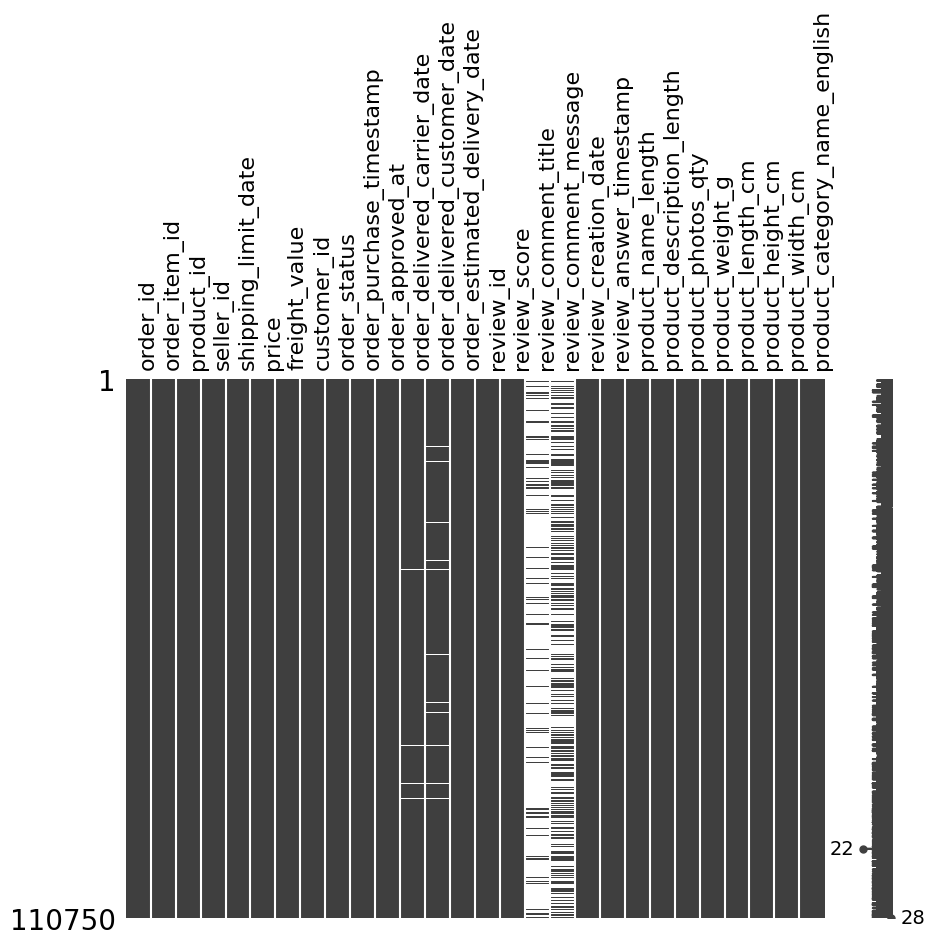

In [39]:
def column_eval(df) -> pd.DataFrame:
    null_count = df.isna().sum()
    total_rows = df.shape[0]
    percent_null = (null_count / total_rows) * 100
    column_dtypes = df.dtypes
    
    null_dataframe = pd.DataFrame(data={"null_count": null_count,
                                        "percent_null": percent_null,
                                        "dytpes": column_dtypes},
                                  index=df.columns)
    return null_dataframe

transactions_eval = column_eval(transactions_df)
display(transactions_eval)
display(msno.matrix(transactions_df, 
                    figsize=(10,7), 
                    label_rotation=90)
        )

##### Dealing with null values

<Axes: >

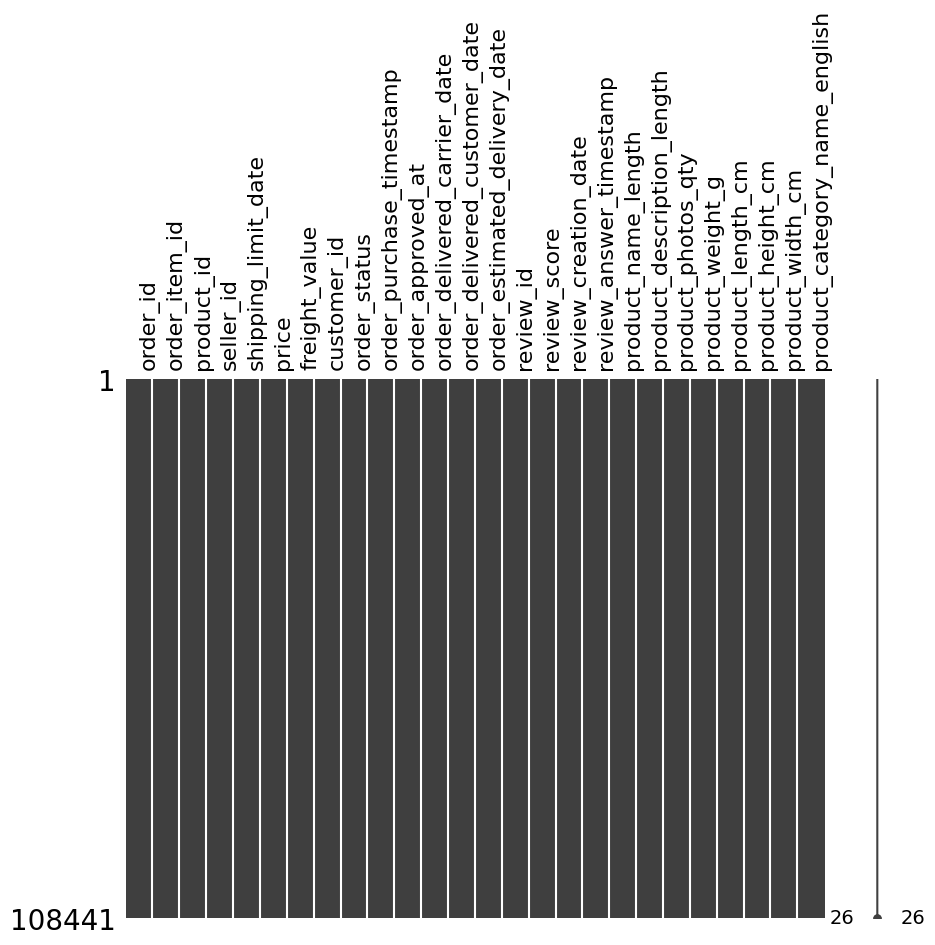

In [40]:
#  remove columns with more than 50% empty values
mostly_null_columns = transactions_eval.query("percent_null > 50").index
transactions_df = transactions_df.drop(columns=mostly_null_columns)

#  remove rows with null values
transactions_df = transactions_df.dropna(axis=0)

display(msno.matrix(transactions_df, 
                    figsize=(10,7), 
                    label_rotation=90)
        )

#### Checking for duplicates in the dataset

In [41]:
duplicated = transactions_df.duplicated(subset=["order_id",
                                               "order_item_id",
                                               "product_id",
                                               "customer_id",
                                               "price"
                                               ])

duplicates = transactions_df[duplicated]

sample_duplicate = duplicates.sample().iloc[0,7]

print(f"There are {duplicates.shape[0]} duplicated values")

#  sample duplicated values from this specific customer
print(f"Sample of duplicated transactions from the same customer (customer ID: {sample_duplicate})")
transactions_df.query("customer_id == @sample_duplicate")

There are 635 duplicated values
Sample of duplicated transactions from the same customer (customer ID: f66c21f1e767f8ae02edfe27c592d698)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_creation_date,review_answer_timestamp,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
94683,ce1813098fb283f84f0b5a7aa63e5fcc,1,9ab61676eb915c81c3c893adca21364c,dc4a0fc896dc34b0d5bfec8438291c80,2017-05-02 02:55:50,83.36,15.79,f66c21f1e767f8ae02edfe27c592d698,delivered,2017-04-19 14:24:05,...,2017-05-05,2017-05-09 11:34:33,56.0,184.0,2.0,650.0,60.0,10.0,50.0,bed_bath_table
94684,ce1813098fb283f84f0b5a7aa63e5fcc,1,9ab61676eb915c81c3c893adca21364c,dc4a0fc896dc34b0d5bfec8438291c80,2017-05-02 02:55:50,83.36,15.79,f66c21f1e767f8ae02edfe27c592d698,delivered,2017-04-19 14:24:05,...,2017-05-04,2017-05-22 12:02:34,56.0,184.0,2.0,650.0,60.0,10.0,50.0,bed_bath_table


##### Dealing with duplicate values

In [42]:
#  removing duplicated values
transactions_df = transactions_df.drop_duplicates(subset=["order_id",
                                                          "order_item_id",
                                                          "product_id",
                                                          "customer_id",
                                                          "price"
                                                          ])

print(f"There are now {transactions_df.shape[0]} rows, which is {duplicates.shape[0]} less than before")

There are now 107806 rows, which is 635 less than before


#### Checking categorical values

In [43]:
categorical_cols = transactions_df.loc[:, transactions_df.dtypes == "object"]
categorical_cols.nunique()

order_id                         94472
product_id                       31474
seller_id                         2907
customer_id                      94472
order_status                         2
review_id                        94043
product_category_name_english       71
dtype: int64

In [44]:
filtered_categ_cols = categorical_cols.loc[:, categorical_cols.nunique() < 100]

for col in filtered_categ_cols:
    print(f"Unique values in {col}")
    display(transactions_df[col].unique())

Unique values in order_status


array(['delivered', 'canceled'], dtype=object)

Unique values in product_category_name_english


array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto',
       'home_appliances', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tools_safety', 'cine_p

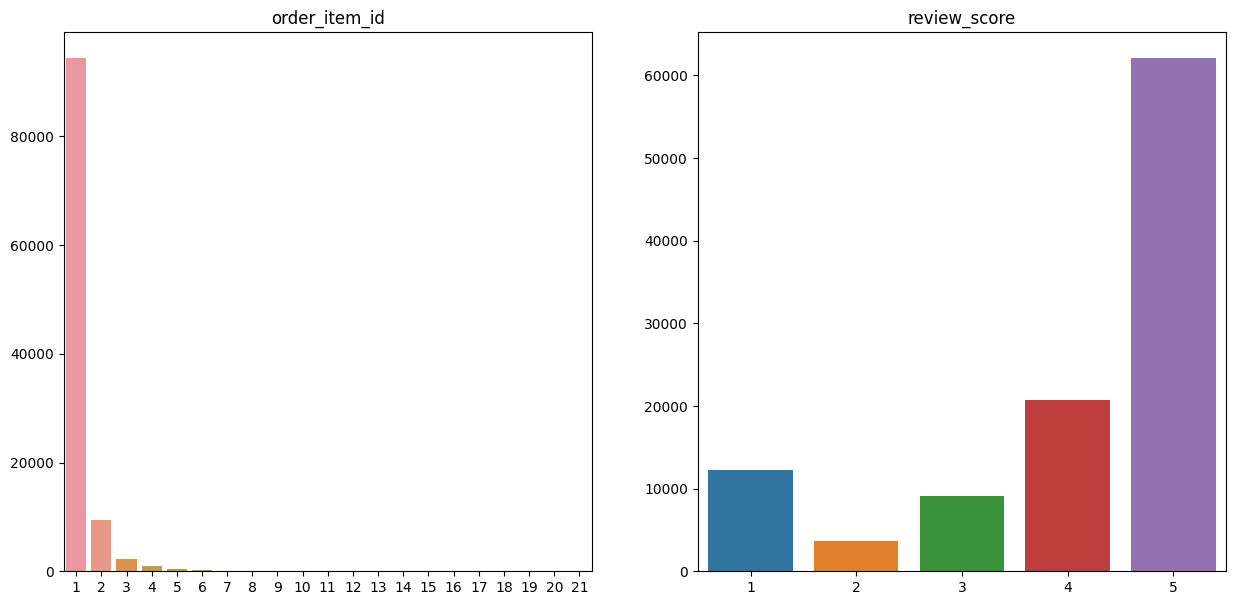

In [45]:
int_cols = transactions_df.loc[:, transactions_df.dtypes == "int64"]

fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(int_cols):
    plt.subplot(1,2,i+1, label=col)
    int_frequency = transactions_df[col].value_counts()
    sns.barplot(x=int_frequency.index, y=int_frequency.values)
    plt.title(col)

#### Checking numerical columns (outlier detection)

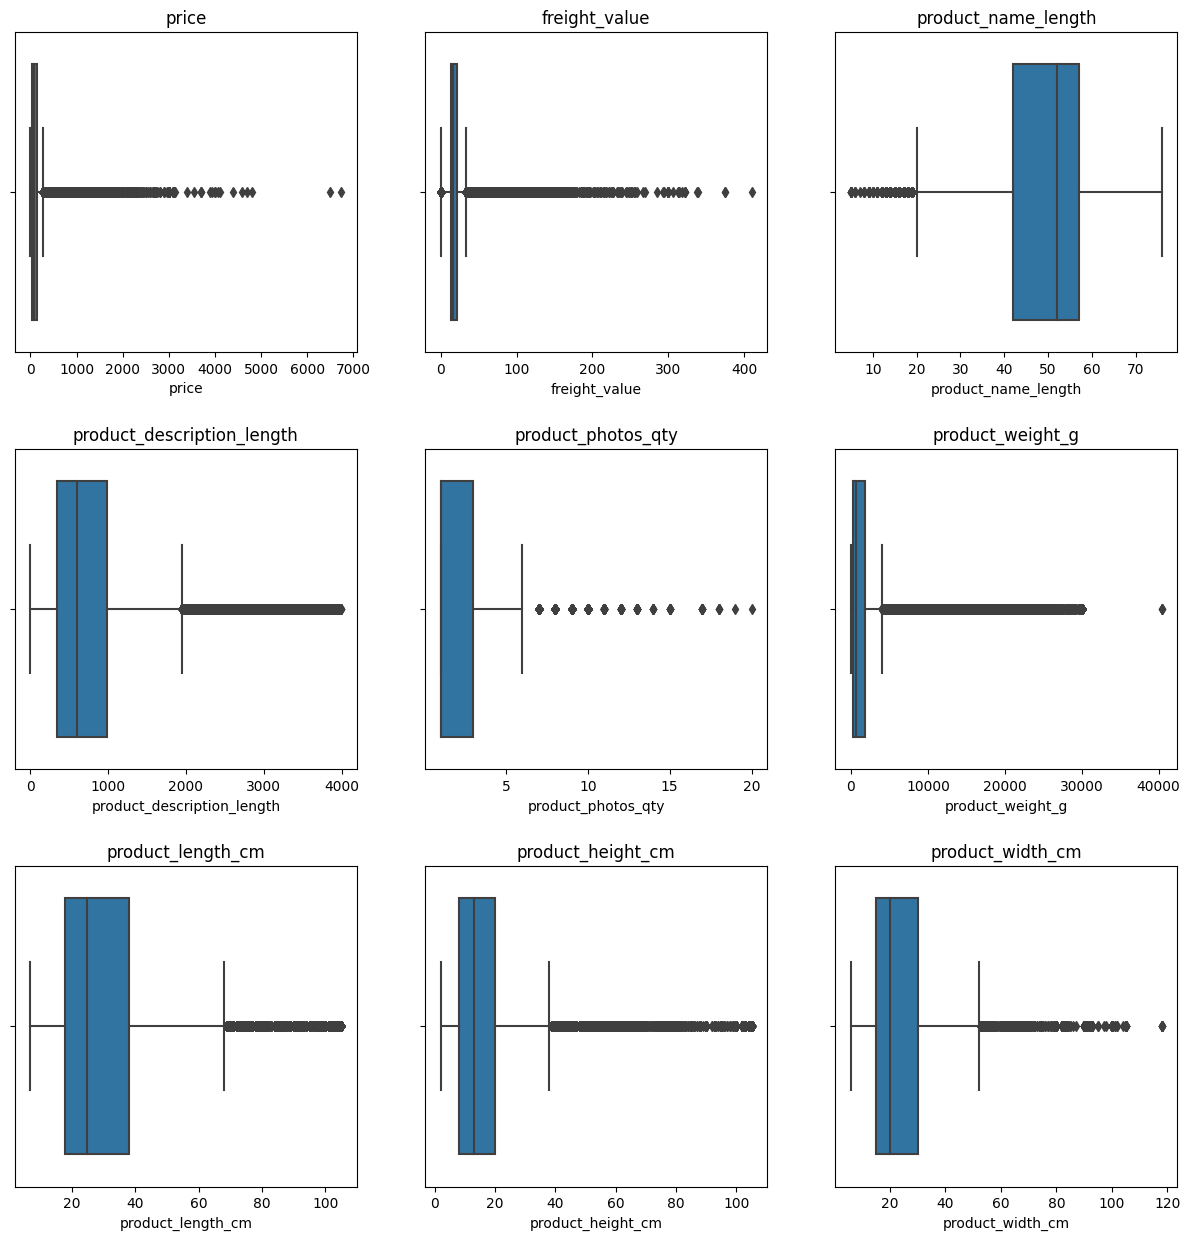

In [46]:
float_cols = transactions_df.loc[:, transactions_df.dtypes == "float64"]

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(float_cols):
    plt.subplot(3,3,i+1, label=col)
    sns.boxplot(data=transactions_df, x=col)
    plt.title(col)

#### Checking datetime columns

In [47]:
datetime_cols = transactions_df.loc[:, transactions_df.dtypes == "datetime64[ns]"]

fig = plt.figure(figsize=(30,10))
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(datetime_cols):
    plt.subplot(2,4,i+1, label=col)
    sns.histplot(data=transactions_df, x=col)
    plt.title(col)

### Feature engineering

#### Feature selection

In [ ]:
relevant_features = ['product_id',
                     'price',
                     'order_purchase_timestamp',
                     'review_score',
                     'product_weight_g',
                     'product_length_cm',
                     'product_height_cm',
                     'product_width_cm',
                     'product_category_name_english',
                     ]

Why are the others deemed irrelevant? yung mga ibang dates can be useful when optimizing price for freight but that's not what we're doing naman

In [ ]:
main_df = transactions_df.copy()
main_df = main_df[relevant_features]
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
74622,ee8c064d6aa1ff4a130e616fab03e284,159.90,2018-03-14 12:04:20,1,10150.0,30.0,47.0,30.0,furniture_decor
77022,aad225c687cc75ba1148d41f2ce414c2,18.90,2017-01-27 09:29:40,4,1300.0,46.0,7.0,12.0,computers_accessories
100311,c5de3a869922e74a2bf19a543f4ac55b,99.00,2018-04-04 19:59:17,5,2220.0,54.0,10.0,11.0,construction_tools_construction
99738,44a5d24dd383324a421569ca697b13c2,29.99,2018-02-21 11:45:07,1,300.0,20.0,20.0,13.0,telephony
110208,2c11cd2167ee0eaaeb45e1f5bf2862d2,119.90,2017-03-19 14:45:15,5,700.0,16.0,20.0,16.0,pet_shop


#### Feature generation

In [ ]:
main_df["day_of_week"] = main_df["order_purchase_timestamp"].dt.day_of_week
main_df["is_weekday"] = main_df["day_of_week"] < 5
main_df["month"] = main_df["order_purchase_timestamp"].dt.month
main_df["year"] = main_df["order_purchase_timestamp"].dt.year
main_df["hour"] = main_df["order_purchase_timestamp"].dt.hour
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,month,year,time,hour
103566,143c616ec3fe0cb065c3805cf9bd812e,26.9,2018-04-19 20:53:13,5,1100.0,30.0,23.0,20.0,garden_tools,3,True,4,2018,20:53:13,20
8051,20566af10fda4783935b8cef249fa4c3,118.9,2018-06-14 20:23:32,5,500.0,22.0,14.0,21.0,watches_gifts,3,True,6,2018,20:23:32,20
79271,be55ae76be8824525f40695d49a5a7b5,76.0,2018-07-25 21:29:05,5,2350.0,18.0,36.0,18.0,agro_industry_and_commerce,2,True,7,2018,21:29:05,21
82829,74cfb67b11aa83ec20fbb297748c8352,59.9,2017-02-07 23:13:17,5,700.0,68.0,7.0,13.0,furniture_decor,1,True,2,2017,23:13:17,23
8473,a35a9f46dcee0a67c8c7ad8493eb4135,27.9,2017-04-03 20:05:04,5,200.0,41.0,2.0,29.0,computers_accessories,0,True,4,2017,20:05:04,20


In [ ]:
main_df["product_volume_cm3"] = main_df["product_length_cm"] * main_df["product_width_cm"] * main_df["product_height_cm"]
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,product_volume_cm3
108493,fdff6fbfaeefd11afe77be6f416e9c4e,5.9,2017-07-20 13:56:18,5,500.0,16.0,26.0,11.0,housewares,3,True,4576.0
63227,b2a11c072dedfc137aa2393bb4a2c8ea,66.9,2017-09-22 20:48:35,4,650.0,22.0,15.0,22.0,cool_stuff,4,True,7260.0
102571,71577b7befec8802e6153ca6b35a793d,28.6,2018-03-04 23:41:08,5,400.0,25.0,12.0,17.0,sports_leisure,6,False,5100.0
82829,74cfb67b11aa83ec20fbb297748c8352,59.9,2017-02-07 23:13:17,5,700.0,68.0,7.0,13.0,furniture_decor,1,True,6188.0
97885,f9a8853f6e322ff0ff068ca9f315b5d5,27.9,2018-04-01 22:45:22,5,250.0,30.0,30.0,30.0,stationery,6,False,27000.0


### Final diagnosis of main_df

In [ ]:
main_df.sample(5)

,product_id,price,order_purchase_timestamp,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_weekday,product_volume_cm3
93243,bd0ced5367f8750ffbeaa23d1d2ddf33,49.90,2018-05-21 11:18:44,4,800.0,25.0,21.0,25.0,construction_tools_construction,0,True,13125.0
88661,13ad6994bda56edfa0a269e3d9a9acb3,89.90,2017-02-19 19:53:52,4,600.0,17.0,15.0,13.0,auto,6,False,3315.0
28271,1dfb36d969d347f56f43590ec42c7b8c,159.99,2018-04-05 14:55:22,2,900.0,26.0,6.0,13.0,sports_leisure,3,True,2028.0
106508,f132b7df45fae1b7f60550c5ae81aa57,113.37,2018-08-21 17:03:40,5,250.0,18.0,9.0,14.0,furniture_decor,1,True,2268.0
80303,b4ac82f28d4cd68c12ce7934bebac9c5,59.00,2018-05-02 09:59:31,4,400.0,25.0,12.0,20.0,computers_accessories,2,True,6000.0


In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107806 entries, 0 to 110749
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_id                     107806 non-null  object        
 1   price                          107806 non-null  float64       
 2   order_purchase_timestamp       107806 non-null  datetime64[ns]
 3   review_score                   107806 non-null  int64         
 4   product_weight_g               107806 non-null  float64       
 5   product_length_cm              107806 non-null  float64       
 6   product_height_cm              107806 non-null  float64       
 7   product_width_cm               107806 non-null  float64       
 8   product_category_name_english  107806 non-null  object        
 9   day_of_week                    107806 non-null  int64         
 10  is_weekday                     107806 non-null  bool          
 11  

In [ ]:
main_row, main_col = main_df.shape

print(f"main_df has a total of {main_row} entries and {main_col} features.")

main_df has a total of 107806 entries and 12 features.


## Exploratory Data Analysis (EDA)

### Sampling for our dataset

In [ ]:
#  sampling code goes here

### Checking out distribution of features

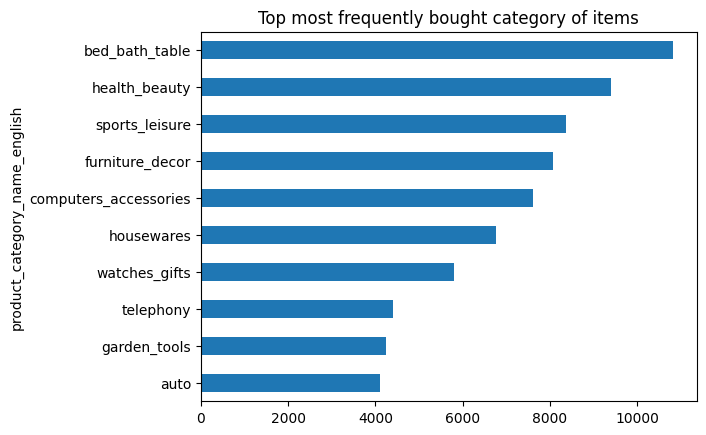

In [ ]:
(main_df
 .groupby("product_category_name_english")["product_id"]
 .count()
 .sort_values(ascending=False)
 .head(10)
 .plot
 .barh(title="Top most frequently bought category of items")
 .invert_yaxis()
 )

<Axes: title={'center': 'Purchase made on a weekday?'}>

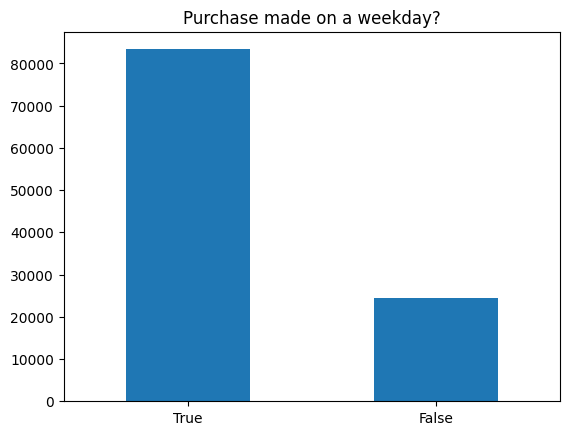

In [ ]:
(main_df.is_weekday
 .value_counts()
 .plot
 .bar(rot=0,
      title="Purchase made on a weekday?")
 )

Text(0.5, 0, '[0] Monday - [6] Sunday')

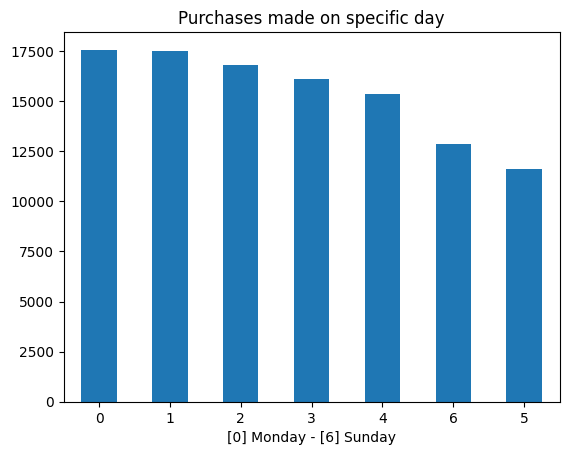

In [ ]:
(main_df
 .day_of_week.
 value_counts()
 .plot
 .bar(rot=0,
      title="Purchases made on specific day"
      )
 )
plt.xlabel("[0] Monday - [6] Sunday")

<Axes: title={'center': 'Distribution of review scores'}>

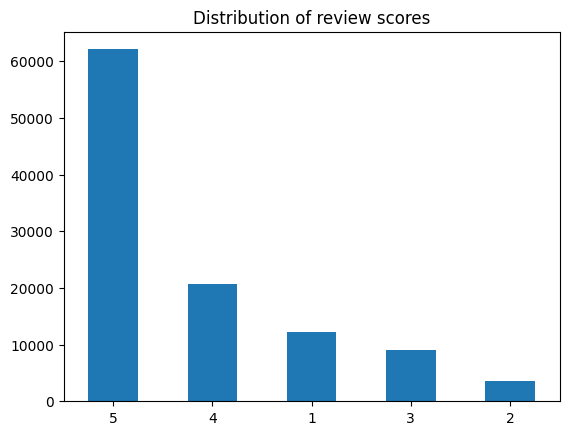

In [ ]:
(main_df
 .review_score
 .value_counts()
 .plot
 .bar(rot=0,
      title="Distribution of review scores"))